<a href="https://colab.research.google.com/github/asgardsun/Content-Based-Recommendation/blob/main/Simple_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##간단한 추천 시스템 만들기

In [1]:
import pandas as pd


In [4]:
ratings=pd.read_pickle('/content/drive/MyDrive/recommendation/data/ratings_updated.p')

In [ ]:
ratings

###RMSE

In [6]:
rating_example = [[4, 3.5], [5,5], [0.5,1], [3,5]]
rating_example = pd.DataFrame(rating_example, columns=['Actual','Predict'])

In [8]:
#error = Actual - Predict
rating_example['error'] = rating_example['Actual'] - rating_example['Predict']

In [13]:
#squared error: +와 -가 캔슬되는 것을 막기 위해서
rating_example['squared error']= rating_example['error'] ** 2

In [17]:
#mean squared error : mse
mse = rating_example['squared error'].mean()
mse

1.125

In [18]:
import numpy as np

In [20]:
#root mean squared error : rmse
rmse = np.sqrt(mse)
rmse

1.0606601717798212

###RMSE with sklearn

In [21]:
from sklearn.metrics import mean_squared_error

In [22]:
mean_squared_error(rating_example['Actual'], rating_example['Predict'])
rmse = np.sqrt(mse)
rmse

1.0606601717798212

###Train Test Split

In [23]:
from sklearn.model_selection import train_test_split

In [26]:
train, test = train_test_split(ratings, random_state=42, test_size=0.1)

In [27]:
print(train.shape)
print(test.shape)

(90764, 4)
(10085, 4)


###가장 간단한 예측하기

In [28]:
test.shape

(10085, 4)

In [31]:
prediction = [0.5] * len(test)

In [32]:
#mean_squared_error(actual, predict)
mse = mean_squared_error(test['rating'], prediction)
rmse = np.sqrt(mse)
rmse

3.174432284238969

###모두 0.5점으로 예측하기

In [34]:
predictions = [0.5] * len(test)

In [35]:
mse = mean_squared_error(test['rating'],predictions)
rmse = np.sqrt(mse)
rmse

3.174432284238969

###모두 5점으로 예측하기

In [39]:
predictions = [5] * len(test)

In [40]:
mse = mean_squared_error(test['rating'],predictions)
rmse = np.sqrt(mse)
rmse

1.8338928849676452

###데이터의 평균으로 예측하기
  - 주의점 : train 데이터의 평균으로 test 데이터의 평균을 예측해야 함

In [42]:
rating_avg = train['rating'].mean()
rating_avg

3.5022916574853467

In [43]:
predictions = [rating_avg] * len(test)

In [44]:
mse = mean_squared_error(test['rating'],predictions)
rmse = np.sqrt(mse)
rmse

1.0493517883746413

###사용자 평점 기반 예측하기 
    -각 사용자의 평균 평점으로(train), 영화에 대한 평점을 예측(test)하기
    -train에 해당 사용자에 대한 평점 기록이 전혀 없다면, 어떻게 해야할까
    -Ex) userid 1번의 train 데이터상 평균 평점을 4.33이라고 한다면, userid 1번의 test 데이터에 대한 모든 영화 평점을 4.33으로 한다.
    -이 예측 방법은 어떤 가정을 가지고있는지, 예측 근거를 찾아보기

In [48]:
users = train.groupby('userId')['rating'].mean().reset_index()
users = users.rename(columns={'rating' : 'predict'})
users

,userId,predict
0,1,4.333333
1,2,3.925926
2,3,2.529412
3,4,3.512690
4,5,3.627907
...,...,...
606,607,3.794286
607,608,3.143142
608,609,3.277778
609,610,3.685264


In [51]:
predict_by_users = test.merge(users, how='left', on='userId')
predict_by_users

,userId,movieId,rating,timestamp,predict
0,387,1303,3.5,2004-09-11 04:24:43,3.248377
1,81,367,1.0,1996-10-14 13:30:44,2.714286
2,419,1350,4.0,2011-10-11 12:57:59,3.839552
3,13,4011,5.0,2001-04-21 23:27:31,3.607143
4,159,63082,0.5,2017-10-22 02:44:46,3.264706
...,...,...,...,...,...
10080,357,339,3.5,2012-09-26 02:57:00,3.961652
10081,474,8809,4.0,2005-09-19 15:22:17,3.391684
10082,318,78209,3.5,2015-02-21 19:28:11,3.755089
10083,474,5505,4.5,2004-11-10 20:52:54,3.391684


In [55]:
predict_by_users.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
predict      0
dtype: int64

In [58]:
mse = mean_squared_error(predict_by_users['rating'], predict_by_users['predict'])
rmse = np.sqrt(mse)
rmse

0.9449957767928697

####예측의 근거

In [59]:
train['rating'].std()

1.0417955148129747

In [63]:
train.groupby('userId')['rating'].std().mean()

0.9275663818235674

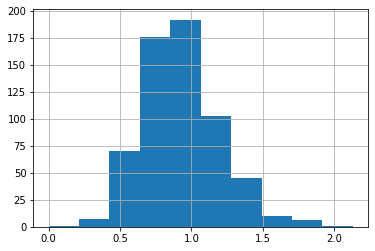

In [64]:
train.groupby('userId')['rating'].std().hist()

###영화 평점 기반 예측하기
    -각 영화의 평균 평점으로(train), 영화에 대한 평점을 예측(test)하기
	-train에 해당 영화에 대한 평점기록이 전혀 없다면, 어떻게 해야할까
	-ex) moved 1번의 train 데이터상 평균 평점을 4.5라고 한다면, movieid 1번의 test 데이터에 대한 모든 영화 평점을 4.5로 한다.
	-이 예측 방법은 어떤 가정을 가지고 있는지, 예측 근거를 찾아보기

In [66]:
movies = train.groupby('movieId')['rating'].mean().reset_index()
movies = movies.rename(columns={'rating':'predict'})
movies[:1]

,movieId,predict
0,1,3.954545


In [72]:
predict_by_movies = test.merge(movies, how='left', on='movieId')
predict_by_movies.sample()

,userId,movieId,rating,timestamp,predict
2189,509,455,3.0,2015-07-04 08:40:08,2.363636


In [73]:
predict_by_movies.isnull().sum()

userId         0
movieId        0
rating         0
timestamp      0
predict      380
dtype: int64

In [79]:
predict_by_movies.loc[predict_by_movies['predict'].isnull(), 'predict'] = train['rating'].mean()

In [80]:
mean_squared_error(predict_by_movies['rating'],predict_by_movies['predict'])
rmse = np.sqrt(mse)
rmse

0.9449957767928697